**MNIST: Model tuning and Transfer Learning**

`Ilya Borovik, BS4-DS`

## Preparation

Settign up libraries and defining datasets for the tasks

### Libraries

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt

import os
import time
import copy

In [0]:
RANDOM_SEED = 23
torch.manual_seed(RANDOM_SEED)

In [0]:
# train on cuda if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

### Datasets

Defining data transformations and loading MNIST data

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]),
}

In [0]:
train_set = datasets.MNIST('./data', train=True, download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                           ]))

test_set = datasets.MNIST('./data', train=False, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))
                          ]))

Processing...
Done!


Building masks for digits from 0-4 and 5-9

In [0]:
digits_04 = [0, 1, 2, 3, 4]
digits_59 = [5, 6, 7, 8, 9]

train_digits_04 = np.where(train_set.train_labels < 5)[0]
train_digits_59 = np.where(train_set.train_labels > 4)[0]

test_digits_04 = np.where(test_set.test_labels < 5)[0]
test_digits_59 = np.where(test_set.test_labels > 4)[0]

(len(train_digits_04), len(test_digits_04)), (len(train_digits_59), len(test_digits_59))

((30596, 5139), (29404, 4861))

### Data loaders

In [0]:
def build_dataloaders(train_indices, test_indices, batch_size=128):
    """ Returns dataloaders and dataset_sizes """
    dataloaders = {
        'train': torch.utils.data.DataLoader(
            train_set, batch_size=batch_size, 
            sampler=SubsetRandomSampler(train_indices)
        ),
        'valid': torch.utils.data.DataLoader(
            test_set, batch_size=batch_size, 
            sampler=SubsetRandomSampler(test_indices)
        )
    }
    dataset_sizes = {
        'train': len(train_indices),
        'valid': len(test_indices)
    }
    return dataloaders, dataset_sizes

Tensors to Numpy arrays

In [0]:
def data_to_numpy(train_indices, test_indices):
    batch_size=max(len(train_indices), len(test_indices))
    dataloaders, dataset_sizes = build_dataloaders(train_indices, test_indices, batch_size)

    for inputs, labels in dataloaders['train']:
        X_train = inputs.view(-1, 28*28).data.numpy()
        y_train = labels.data.numpy()
        
    for inputs, labels in dataloaders['valid']:
        X_valid = inputs.view(-1, 28*28).data.numpy()
        y_valid = labels.data.numpy()

    return X_train, y_train, X_valid, y_valid

### Vizualization

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Part 1: Deep Learning

Learning and tuning a model on MNIST digits 0-4.

## Datasets

Getting a subset of MNIST for digits 0-4.


In [0]:
dataloaders_04, dataset_sizes_04 = build_dataloaders(train_digits_04, test_digits_04, batch_size=128)
dataset_sizes_04

{'train': 30596, 'valid': 5139}

In [0]:
X_train_04, y_train_04, X_valid_04, y_valid_04 = data_to_numpy(train_digits_04, test_digits_04)
(X_train_04.shape, y_train_04.shape), (X_valid_04.shape, y_valid_04.shape)

(((30596, 784), (30596,)), ((5139, 784), (5139,)))

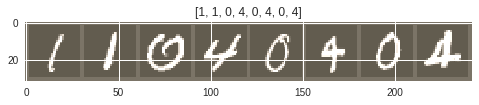

In [0]:
inputs, classes = next(iter(dataloaders_04['train']))
inputs, classes = inputs[:8], classes[:8]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[digits_04[x] for x in classes])

## Training and vizualization functions

In [0]:
def train_model(model, X_train, y_train, criterion, optimizer, 
                batch_size=128, X_valid=None, y_valid=None,
                scheduler=None, n_epochs=25, early_stopping=5, verbose=True):
    since = time.time()

    best_model_wts = None
    best_acc = 0.0
    n_epochs_no_impr = 0
    
    losses = {'train': [], 'valid': []}
    accs = {'train': [], 'valid': []}
    
    # building data loaders
    dataset_sizes = {'train': X_train.shape[0]}
    X_train = torch.Tensor(X_train)
    y_train = torch.LongTensor(y_train)
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train, y_train), 
        batch_size=batch_size, shuffle=True,
    )
    dataloaders = {'train': train_loader}

    if X_valid is not None and y_valid is not None:
        dataset_sizes['valid'] = X_valid.shape[0]
        X_valid = torch.Tensor(X_valid)
        y_valid = torch.LongTensor(y_valid)
        val_loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(X_valid, y_valid), 
            batch_size=batch_size, shuffle=True,
        )
        phases = ['train', 'valid']

        dataloaders['valid'] = val_loader
    else:
        phases = ['train']

    phases = dataloaders.keys()
    for epoch in range(1, n_epochs+1):
        if verbose:
            print('Epoch {}/{}'.format(epoch, n_epochs))

        # each epoch has a training and validation phase
        for phase in phases:
            if phase == 'train':
                if scheduler is not None:
                    scheduler.step()
                model.train()  # set model to training mode
            else:
                model.eval()   # set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # iterate over data
            for inputs, labels in dataloaders[phase]:
                # inputs = inputs.view(-1, 28*28)
              
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            losses[phase].append(epoch_loss)
            accs[phase].append(epoch_acc)

            if verbose:
                print(' - {:5s} loss: {:.4f} acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    n_epochs_no_impr = 0
                else:
                    n_epochs_no_impr += 1
        
        if n_epochs_no_impr >= early_stopping:
            # stop early
            if verbose:
                print('Early stopping')
            break

    time_elapsed = time.time() - since
    if verbose:
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:.4f}'.format(best_acc))

    # load best model weights
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
    
    return model, losses, accs

In [0]:
def visualize_model(model, dataloaders, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs_m = inputs.view(-1, 28*28)
            inputs_m = inputs_m.to(device)
            labels = labels.to(device)

            outputs = model(inputs_m)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
        
def plot_metrics(ax, values, metric_name='accuracy', model_name='model'):
    for key in values.keys():
        ax.plot(values[key])
    
    ax.legend(values.keys())
    ax.set_title(f'{model_name} {metric_name} values')
    ax.set_xlabel('epoch')
    ax.set_ylabel('value')

## 1. DNN with 5 hidden layers 

In [0]:
input_dim = 28*28
hidden_dim = 100
output_dim = 5

class DNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=100, n_hidden_layers=5, 
                 activation=F.elu, batch_norm=None, dropout_prob=0.):
        super(DNN, self).__init__()
        self.n_hidden_layers = n_hidden_layers
        self.activation = activation
        self.batch_norm = batch_norm
        self.dropout_prob = dropout_prob
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        
        self._fc = [self.fc1, self.fc2, self.fc3, self.fc4, self.fc5]
        
        if batch_norm is not None:
            self.bn1 = nn.BatchNorm1d(hidden_dim)
            self.bn2 = nn.BatchNorm1d(hidden_dim)
            self.bn3 = nn.BatchNorm1d(hidden_dim)
            self.bn4 = nn.BatchNorm1d(hidden_dim)
            self.bn5 = nn.BatchNorm1d(hidden_dim)
            
            self._bn = [self.bn1, self.bn2, self.bn3, self.bn4, self.bn5]
  
        self.out = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        for i in range(self.n_hidden_layers):
            x = self._fc[i](x)
            if self.batch_norm:
                x = self._bn[i](x)
            x = self.activation(x)
            x = F.dropout(x, p=self.dropout_prob, training=self.training)
        
        return F.softmax(self.out(x), dim=1)
      
def init_he_normal(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_normal_(m.weight)

In [0]:
torch.manual_seed(RANDOM_SEED)

model_base = DNN(input_dim, output_dim, hidden_dim)
model_base = model_base.apply(init_he_normal)  # He initialization

## 2. Training a model with early stopping

In [0]:
model_base = model_base.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_base.parameters(), lr=1e-3)

model_base, losses_base, accs_base = train_model(
    model_base, X_train_04, y_train_04, 
    criterion, optimizer, 
    X_valid=X_valid_04, y_valid=y_valid_04, batch_size=128,
    n_epochs=25, early_stopping=7
)

Epoch 1/25
 - train loss: 0.9527 acc: 0.9528
 - valid loss: 0.9534 acc: 0.9508
Epoch 2/25
 - train loss: 0.9308 acc: 0.9737
 - valid loss: 0.9261 acc: 0.9784
Epoch 3/25
 - train loss: 0.9266 acc: 0.9782
 - valid loss: 0.9225 acc: 0.9821
Epoch 4/25
 - train loss: 0.9244 acc: 0.9804
 - valid loss: 0.9215 acc: 0.9833
Epoch 5/25
 - train loss: 0.9233 acc: 0.9813
 - valid loss: 0.9350 acc: 0.9698
Epoch 6/25
 - train loss: 0.9225 acc: 0.9821
 - valid loss: 0.9244 acc: 0.9800
Epoch 7/25
 - train loss: 0.9259 acc: 0.9788
 - valid loss: 0.9327 acc: 0.9716
Epoch 8/25
 - train loss: 0.9452 acc: 0.9596
 - valid loss: 0.9247 acc: 0.9800
Epoch 9/25
 - train loss: 0.9269 acc: 0.9778
 - valid loss: 0.9231 acc: 0.9815
Epoch 10/25
 - train loss: 0.9242 acc: 0.9806
 - valid loss: 0.9256 acc: 0.9790
Epoch 11/25
 - train loss: 0.9221 acc: 0.9826
 - valid loss: 0.9216 acc: 0.9831
Early stopping
Training complete in 0m 15s
Best val Acc: 0.9833


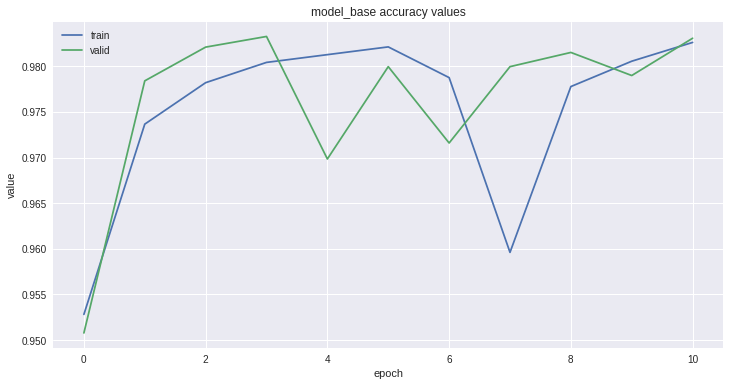

In [0]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_metrics(ax, accs_base, metric_name='accuracy', model_name='model_base')

## 3. Hyper-parameter tuning

Tuning `batch_size`,  `learning_rate`.

To use GridSearchCV, we define a sklearn compatible Classifier, a wrapper arounf our DNN model class.

In [0]:
from sklearn.base import BaseEstimator, ClassifierMixin

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, hidden_dim=100,
                 learning_rate=0.001, batch_size=128, 
                 activation=F.elu, initializer=init_he_normal,
                 batch_norm=None, dropout_prob=0., random_state=None):
        self.n_hidden_layers = n_hidden_layers
        self.hidden_dim = hidden_dim
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm = batch_norm
        self.dropout_prob = dropout_prob
        self.random_state = random_state

    def _dnn(self, inputs):
        """Build the hidden layers, with support for batch normalization and dropout."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_model(self, n_inputs, n_outputs):
        """Build the same model as earlier"""
        if self.random_state is not None:
            torch.manual_seed(self.random_state)
            np.random.seed(self.random_state)
            
        model = DNN(n_inputs, n_outputs, self.hidden_dim, 
                    n_hidden_layers=self.n_hidden_layers, activation=self.activation,
                    dropout_prob=self.dropout_prob, batch_norm=self.batch_norm)
        model.apply(self.initializer)  # He initialization

        self.model = model.to(device)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=self.learning_rate)

    def fit(self, X, y, n_epochs=10, X_valid=None, y_valid=None, early_stopping=7, verbose=False):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping."""

        # infer n_inputs and n_outputs from the training set.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)

        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)

        self._build_model(n_inputs, n_outputs)
            
        self.model, _, _ = train_model(
            self.model, X, y, 
            self.criterion, self.optimizer, 
            batch_size=self.batch_size, X_valid=X_valid, y_valid=y_valid,
            n_epochs=n_epochs, early_stopping=early_stopping,
            verbose=verbose
        )    
        
        return self
    
    def predict(self, X):
        X = torch.Tensor(X)
        X = X.to(device)
        outputs = self.model(X)
        _, preds = torch.max(outputs, 1)
        return np.array([[self.classes_[class_index]]
                         for class_index in preds], np.int32)

    def save(self, path):
        torch.save(self.model.state_dict(), path)

In [0]:
from sklearn.model_selection import RandomizedSearchCV

def print_k_best(gs_clf, k=10):
    """ Pretty Grid Search results outputs """
    ranks = gs_clf.cv_results_['rank_test_score']
    ranks = np.argsort(ranks)

    for _ in range(k):
        print(_+1, gs_clf.cv_results_['mean_test_score'][ranks[_]], 
              gs_clf.cv_results_['params'][ranks[_]])

Testing DNNClassifier before Grid Search

In [0]:
dnn_clf = DNNClassifier(random_state=RANDOM_SEED)
dnn_clf = dnn_clf.fit(X_train_04, y_train_04, n_epochs=5, 
                      X_valid=X_valid_04, y_valid=y_valid_04, verbose=True)

Epoch 1/5
 - train loss: 0.9527 acc: 0.9528
 - valid loss: 0.9534 acc: 0.9508
Epoch 2/5
 - train loss: 0.9308 acc: 0.9737
 - valid loss: 0.9261 acc: 0.9784
Epoch 3/5
 - train loss: 0.9266 acc: 0.9782
 - valid loss: 0.9225 acc: 0.9821
Epoch 4/5
 - train loss: 0.9244 acc: 0.9804
 - valid loss: 0.9215 acc: 0.9833
Epoch 5/5
 - train loss: 0.9233 acc: 0.9813
 - valid loss: 0.9350 acc: 0.9698
Training complete in 0m 7s
Best val Acc: 0.9833


Tuning hyperparameters

In [0]:
param_distribs = {
    "batch_size": [32, 64, 128, 256, 512],
    "learning_rate": [1e-2, 1e-3, 1e-4, 1e-5],
}

gs_model = RandomizedSearchCV(DNNClassifier(random_state=RANDOM_SEED), 
                              param_distribs, n_iter=50, cv=3,
                              random_state=RANDOM_SEED, verbose=10, scoring='accuracy', refit=False)

gs_model.fit(X_train_04, y_train_04, n_epochs=50, 
             X_valid=X_valid_04, y_valid=y_valid_04,
             early_stopping=7)

print_k_best(gs_model)

1 0.9864688194535234 {'learning_rate': 0.001, 'batch_size': 256}
2 0.9863053993986142 {'learning_rate': 0.0001, 'batch_size': 32}
3 0.9854882991240685 {'learning_rate': 0.001, 'batch_size': 512}
4 0.9851614590142502 {'learning_rate': 0.0001, 'batch_size': 64}
5 0.9836253104981043 {'learning_rate': 0.0001, 'batch_size': 128}
6 0.9832984703882861 {'learning_rate': 0.0001, 'batch_size': 256}
7 0.9820564779709766 {'learning_rate': 0.0001, 'batch_size': 512}
8 0.9814027977513401 {'learning_rate': 0.001, 'batch_size': 128}
9 0.9806183814877761 {'learning_rate': 1e-05, 'batch_size': 32}
10 0.9803242253889397 {'learning_rate': 1e-05, 'batch_size': 64}


The best parameters are `batch_size=256`, `learning_rate=1e-3`

In [0]:
torch.manual_seed(RANDOM_SEED)

model_tuned = DNN(input_dim, output_dim, hidden_dim)
model_tuned.apply(init_he_normal)  # He initialization

model_tuned = model_tuned.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_tuned.parameters(), lr=1e-3)

model_tuned, losses_tuned, accs_tuned = train_model(
    model_tuned, X_train_04, y_train_04, 
    criterion, optimizer, 
    X_valid=X_valid_04, y_valid=y_valid_04, batch_size=256,
    n_epochs=25, early_stopping=7
)

Epoch 1/25
 - train loss: 0.9650 acc: 0.9407
 - valid loss: 0.9246 acc: 0.9802
Epoch 2/25
 - train loss: 0.9267 acc: 0.9782
 - valid loss: 0.9231 acc: 0.9811
Epoch 3/25
 - train loss: 0.9228 acc: 0.9822
 - valid loss: 0.9205 acc: 0.9850
Epoch 4/25
 - train loss: 0.9199 acc: 0.9848
 - valid loss: 0.9158 acc: 0.9893
Epoch 5/25
 - train loss: 0.9174 acc: 0.9877
 - valid loss: 0.9161 acc: 0.9883
Epoch 6/25
 - train loss: 0.9175 acc: 0.9873
 - valid loss: 0.9176 acc: 0.9875
Epoch 7/25
 - train loss: 0.9164 acc: 0.9884
 - valid loss: 0.9156 acc: 0.9891
Epoch 8/25
 - train loss: 0.9157 acc: 0.9890
 - valid loss: 0.9142 acc: 0.9909
Epoch 9/25
 - train loss: 0.9144 acc: 0.9904
 - valid loss: 0.9148 acc: 0.9901
Epoch 10/25
 - train loss: 0.9142 acc: 0.9907
 - valid loss: 0.9164 acc: 0.9879
Epoch 11/25
 - train loss: 0.9131 acc: 0.9916
 - valid loss: 0.9145 acc: 0.9901
Epoch 12/25
 - train loss: 0.9133 acc: 0.9915
 - valid loss: 0.9144 acc: 0.9905
Epoch 13/25
 - train loss: 0.9128 acc: 0.9919
 - 

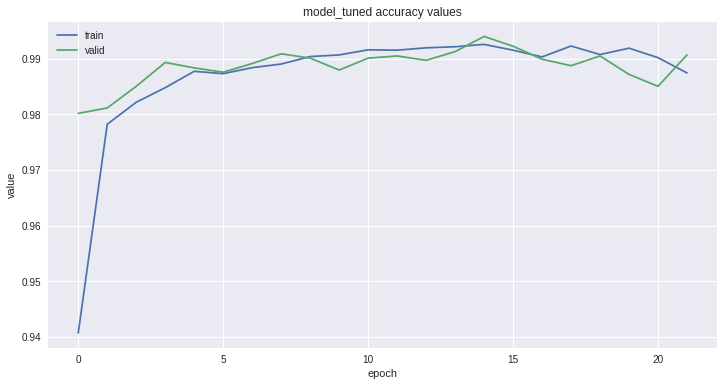

In [0]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_metrics(ax, accs_tuned, metric_name='accuracy', model_name='model_tuned')

## 4. Batch Normalization

Adding Batch Normalization and comparing the results with tuned base model

In [0]:
torch.manual_seed(RANDOM_SEED)

model_bn = DNN(input_dim, output_dim, hidden_dim, batch_norm=True)
model_bn.apply(init_he_normal)  # He initialization

model_bn = model_bn.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_bn.parameters(), lr=1e-3)

model_bn, losses_bn, accs_bn = train_model(
    model_bn, X_train_04, y_train_04, 
    criterion, optimizer, 
    X_valid=X_valid_04, y_valid=y_valid_04, batch_size=256,
    n_epochs=25, early_stopping=7
)

Epoch 1/25
 - train loss: 0.9948 acc: 0.9411
 - valid loss: 0.9348 acc: 0.9788
Epoch 2/25
 - train loss: 0.9344 acc: 0.9766
 - valid loss: 0.9265 acc: 0.9838
Epoch 3/25
 - train loss: 0.9260 acc: 0.9827
 - valid loss: 0.9214 acc: 0.9858
Epoch 4/25
 - train loss: 0.9210 acc: 0.9867
 - valid loss: 0.9197 acc: 0.9866
Epoch 5/25
 - train loss: 0.9179 acc: 0.9891
 - valid loss: 0.9156 acc: 0.9903
Epoch 6/25
 - train loss: 0.9154 acc: 0.9915
 - valid loss: 0.9161 acc: 0.9903
Epoch 7/25
 - train loss: 0.9146 acc: 0.9917
 - valid loss: 0.9147 acc: 0.9914
Epoch 8/25
 - train loss: 0.9129 acc: 0.9935
 - valid loss: 0.9143 acc: 0.9912
Epoch 9/25
 - train loss: 0.9122 acc: 0.9939
 - valid loss: 0.9158 acc: 0.9891
Epoch 10/25
 - train loss: 0.9117 acc: 0.9941
 - valid loss: 0.9153 acc: 0.9907
Epoch 11/25
 - train loss: 0.9104 acc: 0.9954
 - valid loss: 0.9127 acc: 0.9924
Epoch 12/25
 - train loss: 0.9099 acc: 0.9958
 - valid loss: 0.9121 acc: 0.9936
Epoch 13/25
 - train loss: 0.9090 acc: 0.9967
 - 

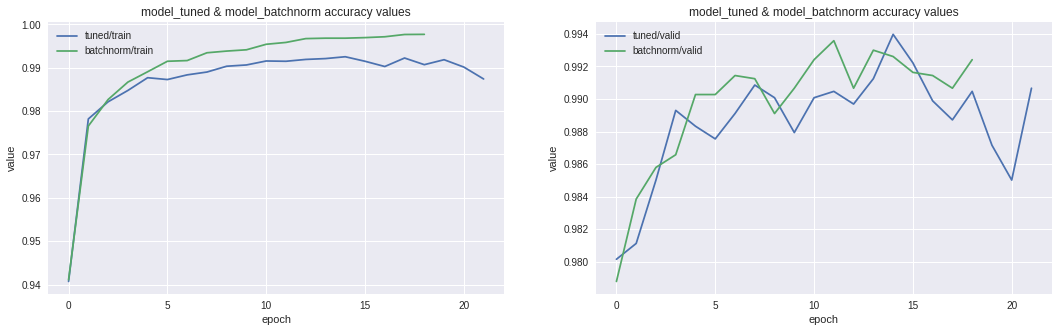

In [0]:
values_train = {
    'tuned/train': accs_tuned['train'], 
    'batchnorm/train': accs_bn['train'], 
}

values_valid = {
    'tuned/valid': accs_tuned['valid'], 
    'batchnorm/valid': accs_bn['valid'], 
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
plot_metrics(ax1, values_train, metric_name='accuracy', model_name='model_tuned & model_batchnorm')
plot_metrics(ax2, values_valid, metric_name='accuracy', model_name='model_tuned & model_batchnorm')

Converges faster to equal or better results!

## 5. Dropout

Adding Dropout and Tuning dropout probability.

In [0]:
param_distribs = {
    "dropout_prob": [0., 0.01, 0.05, 0.1, 0.2, 0.3]
}

dnn_clf = DNNClassifier(learning_rate=1e-3, batch_size=256, 
                        batch_norm=True, random_state=RANDOM_SEED)

gs_model = RandomizedSearchCV(dnn_clf, param_distribs, n_iter=6, cv=3,
                              random_state=RANDOM_SEED, verbose=10, 
                              scoring='accuracy', refit=False)
gs_model.fit(X_train_04, y_train_04, n_epochs=50, 
             X_valid=X_valid_04, y_valid=y_valid_04,
             early_stopping=7)

print_k_best(gs_model, k=6)

1 0.9870244476402144 {'dropout_prob': 0.0}
2 0.9861746633546868 {'dropout_prob': 0.01}
3 0.9853248790691593 {'dropout_prob': 0.1}
4 0.9843443587397045 {'dropout_prob': 0.05}
5 0.9819584259380311 {'dropout_prob': 0.2}
6 0.980258857366976 {'dropout_prob': 0.3}


Dropout does not help.

### The Best Pretrained model

Training and saving the final tuned model!

In [0]:
torch.manual_seed(RANDOM_SEED)

model_best = DNN(input_dim, output_dim, hidden_dim, batch_norm=True)
model_best.apply(init_he_normal)  # He initialization

model_best = model_best.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_best.parameters(), lr=1e-3)

model_best, losses_best, accs_best = train_model(
    model_best, X_train_04, y_train_04, 
    criterion, optimizer, 
    X_valid=X_valid_04, y_valid=y_valid_04, batch_size=256,
    n_epochs=50, early_stopping=7
)

torch.save(model_best.state_dict(), 'model_04_best.pt')

Epoch 1/50
 - train loss: 0.9948 acc: 0.9411
 - valid loss: 0.9348 acc: 0.9788
Epoch 2/50
 - train loss: 0.9344 acc: 0.9766
 - valid loss: 0.9265 acc: 0.9838
Epoch 3/50
 - train loss: 0.9260 acc: 0.9827
 - valid loss: 0.9214 acc: 0.9858
Epoch 4/50
 - train loss: 0.9210 acc: 0.9867
 - valid loss: 0.9197 acc: 0.9866
Epoch 5/50
 - train loss: 0.9179 acc: 0.9891
 - valid loss: 0.9156 acc: 0.9903
Epoch 6/50
 - train loss: 0.9154 acc: 0.9915
 - valid loss: 0.9161 acc: 0.9903
Epoch 7/50
 - train loss: 0.9146 acc: 0.9917
 - valid loss: 0.9147 acc: 0.9914
Epoch 8/50
 - train loss: 0.9129 acc: 0.9935
 - valid loss: 0.9143 acc: 0.9912
Epoch 9/50
 - train loss: 0.9122 acc: 0.9939
 - valid loss: 0.9158 acc: 0.9891
Epoch 10/50
 - train loss: 0.9117 acc: 0.9941
 - valid loss: 0.9153 acc: 0.9907
Epoch 11/50
 - train loss: 0.9104 acc: 0.9954
 - valid loss: 0.9127 acc: 0.9924
Epoch 12/50
 - train loss: 0.9099 acc: 0.9958
 - valid loss: 0.9121 acc: 0.9936
Epoch 13/50
 - train loss: 0.9090 acc: 0.9967
 - 

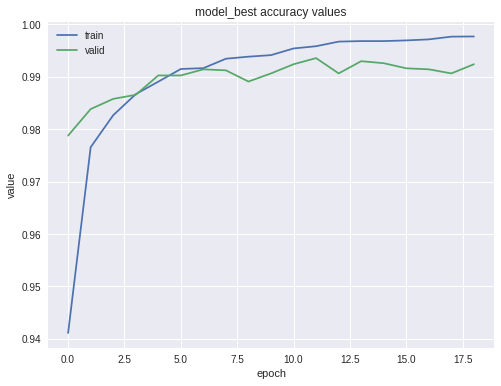

In [0]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_metrics(ax, accs_best, metric_name='accuracy', model_name='model_best')

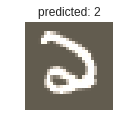

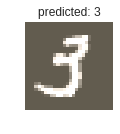

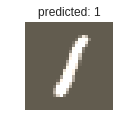

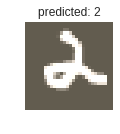

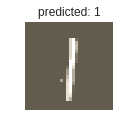

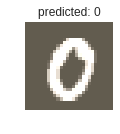

In [0]:
visualize_model(model_best, dataloaders_04, digits_04, num_images=6)

# Part 2: Transfer Learning

## Datasets

Note: Using the whole test set with 5-9 digits as validation, but training set has size 100 observations.

In [0]:
dataloaders_59, dataset_sizes_59 = build_dataloaders(train_digits_59[:100], test_digits_59, batch_size=100)
dataset_sizes_59

{'train': 100, 'valid': 4861}

In [0]:
X_train_59, y_train_59, X_valid_59, y_valid_59 = data_to_numpy(train_digits_59[:100], test_digits_59)

# fixing the issues with labels
y_train_59 = y_train_59 - 5
y_valid_59 = y_valid_59 - 5

(X_train_59.shape, y_train_59.shape), (X_valid_59.shape, y_valid_59.shape)

(((100, 784), (100,)), ((4861, 784), (4861,)))

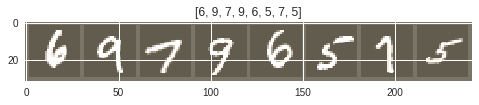

In [0]:
inputs, classes = next(iter(dataloaders_59['train']))
inputs, classes = inputs[:8], classes[:8]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[digits_59[x-5] for x in classes])

## 1. Freezed hidden layers + new softmax

In [0]:
model_trnsf_1 = copy.deepcopy(model_best)
model_trnsf_1

DNN(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=100, bias=True)
  (fc5): Linear(in_features=100, out_features=100, bias=True)
  (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=100, out_features=5, bias=True)
)

In [0]:
torch.manual_seed(RANDOM_SEED)

for param in model_trnsf_1.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_trnsf_1.out = nn.Linear(hidden_dim, output_dim)

## 2. Training the model

Training the last output layer.

Note: use a big number of epochs, because validation accuracy is smoothly improving.

In [0]:
model_trnsf_1 = model_trnsf_1.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_trnsf_1.parameters(), lr=1e-3)

model_trnsf_1, losses_trnsf_1, accs_trnsf_1 = train_model(
    model_trnsf_1, X_train_59, y_train_59, 
    criterion, optimizer, 
    X_valid=X_valid_59, y_valid=y_valid_59, batch_size=256,
    n_epochs=1000, early_stopping=25
)

Epoch 1/1000
 - train loss: 1.5825 acc: 0.2900
 - valid loss: 1.5922 acc: 0.2604
Epoch 2/1000
 - train loss: 1.5766 acc: 0.3300
 - valid loss: 1.5891 acc: 0.2849
Epoch 3/1000
 - train loss: 1.5707 acc: 0.3600
 - valid loss: 1.5858 acc: 0.3094
Epoch 4/1000
 - train loss: 1.5646 acc: 0.4100
 - valid loss: 1.5824 acc: 0.3361
Epoch 5/1000
 - train loss: 1.5585 acc: 0.4300
 - valid loss: 1.5788 acc: 0.3588
Epoch 6/1000
 - train loss: 1.5524 acc: 0.4700
 - valid loss: 1.5752 acc: 0.3767
Epoch 7/1000
 - train loss: 1.5462 acc: 0.5100
 - valid loss: 1.5714 acc: 0.3937
Epoch 8/1000
 - train loss: 1.5399 acc: 0.5300
 - valid loss: 1.5676 acc: 0.4057
Epoch 9/1000
 - train loss: 1.5335 acc: 0.5300
 - valid loss: 1.5637 acc: 0.4129
Epoch 10/1000
 - train loss: 1.5272 acc: 0.5500
 - valid loss: 1.5598 acc: 0.4195
Epoch 11/1000
 - train loss: 1.5208 acc: 0.5700
 - valid loss: 1.5559 acc: 0.4281
Epoch 12/1000
 - train loss: 1.5143 acc: 0.5900
 - valid loss: 1.5520 acc: 0.4300
Epoch 13/1000
 - train lo

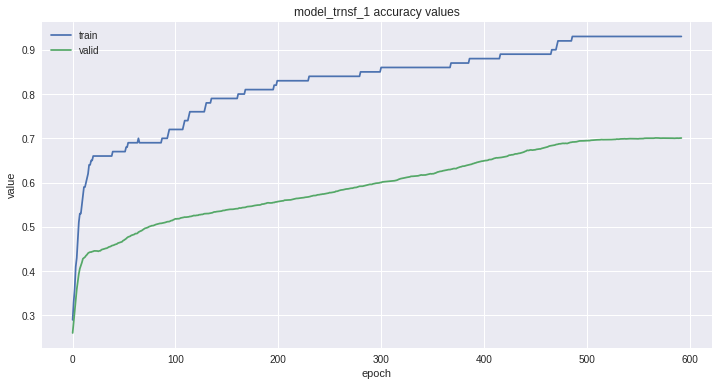

In [0]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_metrics(ax, accs_trnsf_1, metric_name='accuracy', model_name='model_trnsf_1')

## 3. Layer caching

To implement layer caching, we have to slightly modify the model class.

In [0]:
torch.manual_seed(RANDOM_SEED)

model_trnsf_1_frz = copy.deepcopy(model_best)

for param in model_trnsf_1_frz.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_trnsf_1_frz.fc5 = nn.Linear(hidden_dim, hidden_dim)

Changing outputs and saving cached embedings

In [0]:
import types

def forward_truncated(self, x):
    for i in range(self.n_hidden_layers):
        x = self._fc[i](x)
        if self.batch_norm:
            x = self._bn[i](x)
        x = self.activation(x)
        x = F.dropout(x, p=self.dropout_prob, training=self.training)
    return x

model_trnsf_1_frz.forward = types.MethodType(forward_truncated, model_trnsf_1_frz)

In [0]:
def get_model_embed(model, X_train, y_train):
    # building data loaders
    dataset_sizes = {'train': X_train.shape[0]}
    X_train = torch.Tensor(X_train)
    y_train = torch.LongTensor(y_train)
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train, y_train), 
        batch_size=1, shuffle=False,
    )
    dataloaders = {'train': train_loader}
    
    cached_emb = []

    model.eval()   # set model to evaluation mode

    # iterate over data
    for idx, (inputs, labels) in enumerate(dataloaders['train']):
        inputs = inputs.view(-1, 28*28)

        inputs = inputs.to(device)
        outputs = model(inputs)

        cached_emb.append(outputs.cpu().data.numpy())
    
    return np.array(cached_emb).reshape(-1, 100)
  
X_train_59_embed = get_model_embed(model_trnsf_1_frz, X_train_59, y_train_59)
X_valid_59_embed = get_model_embed(model_trnsf_1_frz, X_valid_59, y_valid_59)
X_train_59_embed.shape, X_valid_59_embed.shape

((100, 100), (4861, 100))

Building a new model with only output layer and training it.

In [0]:
class DNNSoftmax(nn.Module):
    def __init__(self, output_dim, hidden_dim=100):
        super(DNNSoftmax, self).__init__()
        self.out = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):        
        return F.softmax(self.out(x), dim=1)

In [0]:
torch.manual_seed(RANDOM_SEED)

model_trnsf_1_cache = DNNSoftmax(output_dim, hidden_dim)
model_trnsf_1_cache.apply(init_he_normal)  # He initialization

model_trnsf_1_cache = model_trnsf_1_cache.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_trnsf_1_cache.parameters(), lr=1e-3)

model_trnsf_1_cache, losses_trnsf_1_cache, accs_trnsf_1_cache = train_model(
    model_trnsf_1_cache, X_train_59_embed, y_train_59, 
    criterion, optimizer, 
    X_valid=X_valid_59_embed, y_valid=y_valid_59, batch_size=256,
    n_epochs=1000, early_stopping=25
)

Epoch 1/1000
 - train loss: 1.6115 acc: 0.1900
 - valid loss: 1.6171 acc: 0.1695
Epoch 2/1000
 - train loss: 1.6076 acc: 0.2200
 - valid loss: 1.6142 acc: 0.1763
Epoch 3/1000
 - train loss: 1.6037 acc: 0.2200
 - valid loss: 1.6114 acc: 0.1800
Epoch 4/1000
 - train loss: 1.5997 acc: 0.2200
 - valid loss: 1.6085 acc: 0.1827
Epoch 5/1000
 - train loss: 1.5957 acc: 0.2200
 - valid loss: 1.6056 acc: 0.1874
Epoch 6/1000
 - train loss: 1.5917 acc: 0.2200
 - valid loss: 1.6027 acc: 0.1915
Epoch 7/1000
 - train loss: 1.5877 acc: 0.2500
 - valid loss: 1.5999 acc: 0.1952
Epoch 8/1000
 - train loss: 1.5837 acc: 0.2600
 - valid loss: 1.5970 acc: 0.2010
Epoch 9/1000
 - train loss: 1.5797 acc: 0.2600
 - valid loss: 1.5941 acc: 0.2059
Epoch 10/1000
 - train loss: 1.5757 acc: 0.2800
 - valid loss: 1.5913 acc: 0.2094
Epoch 11/1000
 - train loss: 1.5717 acc: 0.2800
 - valid loss: 1.5884 acc: 0.2152
Epoch 12/1000
 - train loss: 1.5676 acc: 0.2800
 - valid loss: 1.5855 acc: 0.2177
Epoch 13/1000
 - train lo

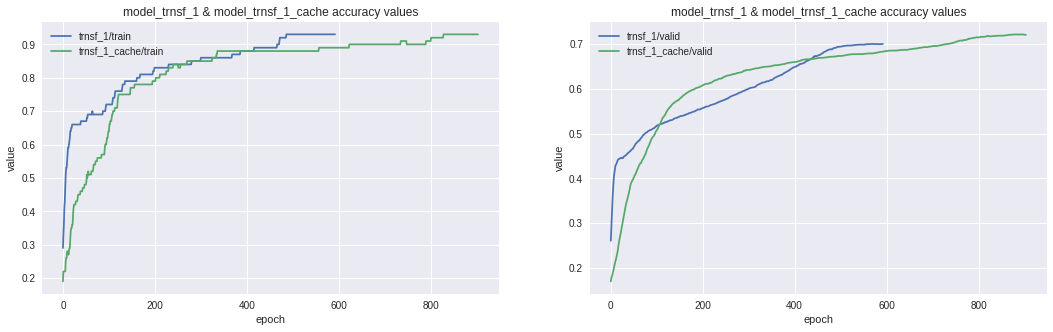

In [0]:
values_train = {
    'trnsf_1/train': accs_trnsf_1['train'], 
    'trnsf_1_cache/train': accs_trnsf_1_cache['train'], 
}

values_valid = {
    'trnsf_1/valid': accs_trnsf_1['valid'], 
    'trnsf_1_cache/valid': accs_trnsf_1_cache['valid'], 
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
plot_metrics(ax1, values_train, metric_name='accuracy', model_name='model_trnsf_1 & model_trnsf_1_cache')
plot_metrics(ax2, values_valid, metric_name='accuracy', model_name='model_trnsf_1 & model_trnsf_1_cache')

## 4. Frozen layers 1-4, training 5 and softmax

In [0]:
torch.manual_seed(RANDOM_SEED)

model_trnsf_2 = copy.deepcopy(model_best)

for param in model_trnsf_2.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_trnsf_2.fc5 = nn.Linear(hidden_dim, hidden_dim)
model_trnsf_2.out = nn.Linear(hidden_dim, output_dim)

In [0]:
model_trnsf_2 = model_trnsf_2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_trnsf_2.parameters(), lr=1e-3)

model_trnsf_2, losses_trnsf_2, accs_trnsf_2 = train_model(
    model_trnsf_2, X_train_59, y_train_59, 
    criterion, optimizer, 
    X_valid=X_valid_59, y_valid=y_valid_59, batch_size=256,
    n_epochs=1000, early_stopping=25
)

Epoch 1/1000
 - train loss: 1.5837 acc: 0.3600
 - valid loss: 1.5867 acc: 0.3275
Epoch 2/1000
 - train loss: 1.5777 acc: 0.3900
 - valid loss: 1.5829 acc: 0.3390
Epoch 3/1000
 - train loss: 1.5717 acc: 0.3900
 - valid loss: 1.5791 acc: 0.3487
Epoch 4/1000
 - train loss: 1.5656 acc: 0.4100
 - valid loss: 1.5752 acc: 0.3547
Epoch 5/1000
 - train loss: 1.5595 acc: 0.4200
 - valid loss: 1.5712 acc: 0.3614
Epoch 6/1000
 - train loss: 1.5533 acc: 0.4200
 - valid loss: 1.5671 acc: 0.3682
Epoch 7/1000
 - train loss: 1.5471 acc: 0.4300
 - valid loss: 1.5631 acc: 0.3736
Epoch 8/1000
 - train loss: 1.5409 acc: 0.4300
 - valid loss: 1.5590 acc: 0.3777
Epoch 9/1000
 - train loss: 1.5347 acc: 0.4400
 - valid loss: 1.5549 acc: 0.3824
Epoch 10/1000
 - train loss: 1.5284 acc: 0.4600
 - valid loss: 1.5508 acc: 0.3878
Epoch 11/1000
 - train loss: 1.5222 acc: 0.4700
 - valid loss: 1.5468 acc: 0.3905
Epoch 12/1000
 - train loss: 1.5159 acc: 0.4900
 - valid loss: 1.5428 acc: 0.3933
Epoch 13/1000
 - train lo

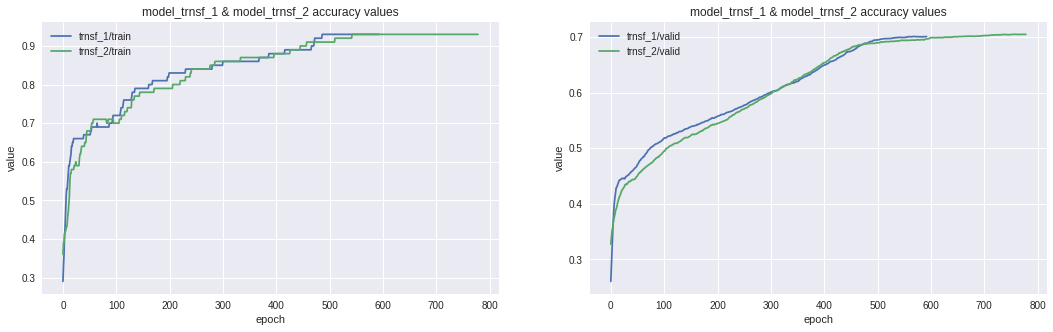

In [0]:
values_train = {
    'trnsf_1/train': accs_trnsf_1['train'], 
    'trnsf_2/train': accs_trnsf_2['train'], 
}

values_valid = {
    'trnsf_1/valid': accs_trnsf_1['valid'], 
    'trnsf_2/valid': accs_trnsf_2['valid'], 
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
plot_metrics(ax1, values_train, metric_name='accuracy', model_name='model_trnsf_1 & model_trnsf_2')
plot_metrics(ax2, values_valid, metric_name='accuracy', model_name='model_trnsf_1 & model_trnsf_2')

Reusing less layers slows down the learning speed, but increases the validation accuracy.

## 5. Frozen layers 1-3, training 4-5 and softmax

In [0]:
torch.manual_seed(RANDOM_SEED)

model_trnsf_3 = copy.deepcopy(model_best)

for param in model_trnsf_3.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_trnsf_3.fc4 = nn.Linear(hidden_dim, hidden_dim)
model_trnsf_3.fc5 = nn.Linear(hidden_dim, hidden_dim)
model_trnsf_3.out = nn.Linear(hidden_dim, output_dim)

In [0]:
model_trnsf_3 = model_trnsf_3.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_trnsf_3.parameters(), lr=1e-3)

model_trnsf_3, losses_trnsf_3, accs_trnsf_3 = train_model(
    model_trnsf_3, X_train_59, y_train_59, 
    criterion, optimizer, 
    X_valid=X_valid_59, y_valid=y_valid_59, batch_size=256,
    n_epochs=1000, early_stopping=50
)

Epoch 1/1000
 - train loss: 1.5994 acc: 0.3100
 - valid loss: 1.6182 acc: 0.2390
Epoch 2/1000
 - train loss: 1.5938 acc: 0.3600
 - valid loss: 1.6150 acc: 0.2695
Epoch 3/1000
 - train loss: 1.5881 acc: 0.3800
 - valid loss: 1.6117 acc: 0.2903
Epoch 4/1000
 - train loss: 1.5823 acc: 0.4000
 - valid loss: 1.6082 acc: 0.3100
Epoch 5/1000
 - train loss: 1.5764 acc: 0.4500
 - valid loss: 1.6046 acc: 0.3222
Epoch 6/1000
 - train loss: 1.5705 acc: 0.4700
 - valid loss: 1.6009 acc: 0.3355
Epoch 7/1000
 - train loss: 1.5645 acc: 0.4800
 - valid loss: 1.5970 acc: 0.3438
Epoch 8/1000
 - train loss: 1.5584 acc: 0.4800
 - valid loss: 1.5932 acc: 0.3542
Epoch 9/1000
 - train loss: 1.5522 acc: 0.4900
 - valid loss: 1.5892 acc: 0.3592
Epoch 10/1000
 - train loss: 1.5460 acc: 0.4900
 - valid loss: 1.5852 acc: 0.3734
Epoch 11/1000
 - train loss: 1.5398 acc: 0.4900
 - valid loss: 1.5812 acc: 0.3810
Epoch 12/1000
 - train loss: 1.5334 acc: 0.4900
 - valid loss: 1.5772 acc: 0.3857
Epoch 13/1000
 - train lo

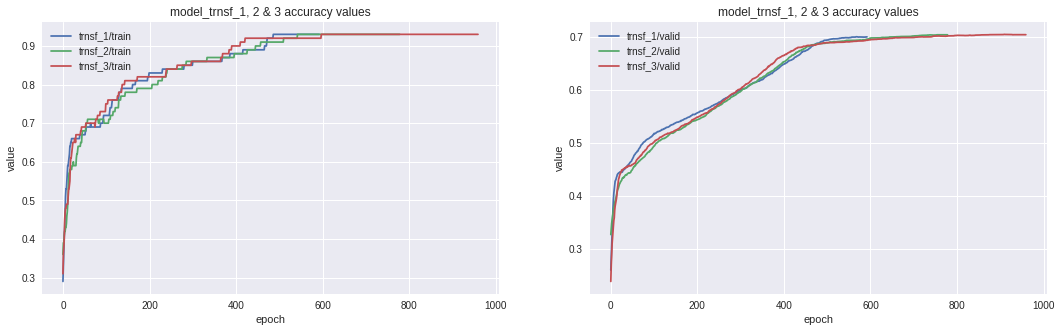

In [0]:
values_train = {
    'trnsf_1/train': accs_trnsf_1['train'], 
    'trnsf_2/train': accs_trnsf_2['train'], 
    'trnsf_3/train': accs_trnsf_3['train'], 
}

values_valid = {
    'trnsf_1/valid': accs_trnsf_1['valid'], 
    'trnsf_2/valid': accs_trnsf_2['valid'], 
    'trnsf_3/valid': accs_trnsf_3['valid'],
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
plot_metrics(ax1, values_train, metric_name='accuracy', model_name='model_trnsf_1, 2 & 3')
plot_metrics(ax2, values_valid, metric_name='accuracy', model_name='model_trnsf_1, 2 & 3')

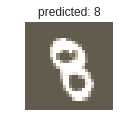

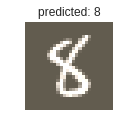

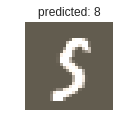

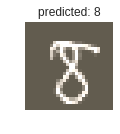

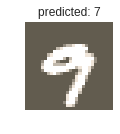

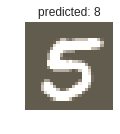

In [0]:
visualize_model(model_trnsf_3, dataloaders_59, digits_59, num_images=6)

## 6*. Training from scratch

In [0]:
torch.manual_seed(RANDOM_SEED)

model_59 = DNN(input_dim, output_dim, hidden_dim, batch_norm=True)
model_59.apply(init_he_normal)  # He initialization

model_59 = model_59.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_59.parameters(), lr=1e-3)

model_59, losses_59, accs_59 = train_model(
    model_59, X_train_59, y_train_59, 
    criterion, optimizer, 
    X_valid=X_valid_59, y_valid=y_valid_59, batch_size=256,
    n_epochs=1000, early_stopping=25
)

Epoch 1/1000
 - train loss: 1.6085 acc: 0.2200
 - valid loss: 1.5911 acc: 0.3306
Epoch 2/1000
 - train loss: 1.4895 acc: 0.5200
 - valid loss: 1.5686 acc: 0.4223
Epoch 3/1000
 - train loss: 1.3897 acc: 0.7100
 - valid loss: 1.5418 acc: 0.4974
Epoch 4/1000
 - train loss: 1.3091 acc: 0.7800
 - valid loss: 1.5112 acc: 0.5495
Epoch 5/1000
 - train loss: 1.2425 acc: 0.8800
 - valid loss: 1.4780 acc: 0.5857
Epoch 6/1000
 - train loss: 1.1874 acc: 0.9300
 - valid loss: 1.4435 acc: 0.6217
Epoch 7/1000
 - train loss: 1.1416 acc: 0.9600
 - valid loss: 1.4094 acc: 0.6499
Epoch 8/1000
 - train loss: 1.1032 acc: 0.9700
 - valid loss: 1.3770 acc: 0.6723
Epoch 9/1000
 - train loss: 1.0706 acc: 0.9900
 - valid loss: 1.3472 acc: 0.6834
Epoch 10/1000
 - train loss: 1.0431 acc: 0.9900
 - valid loss: 1.3205 acc: 0.6970
Epoch 11/1000
 - train loss: 1.0200 acc: 1.0000
 - valid loss: 1.2969 acc: 0.7048
Epoch 12/1000
 - train loss: 1.0007 acc: 1.0000
 - valid loss: 1.2765 acc: 0.7124
Epoch 13/1000
 - train lo